In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
data_path = '../data/twitter-hate-speech.csv'

df = pd.read_csv(data_path, encoding='latin1')
df = df.rename(columns={'does_this_tweet_contain_hate_speech': 'label',  
                        'does_this_tweet_contain_hate_speech:confidence': 'confidence' })

In [3]:
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,label,confidence,_created_at,orig__golden,orig__last_judgment_at,orig__trusted_judgments,orig__unit_id,orig__unit_state,_updated_at,orig_does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech_gold,does_this_tweet_contain_hate_speech_gold_reason,does_this_tweet_contain_hate_speechconfidence,tweet_id,tweet_text
0,853718217,True,golden,86,NaN,The tweet uses offensive language but not hate...,0.6013,NaN,True,NaN,0.0,615561535.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,1.666196e+09,Warning: penny boards will make you a faggot
1,853718218,True,golden,92,NaN,The tweet contains hate speech,0.7227,NaN,True,NaN,0.0,615561723.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,4.295121e+08,Fuck dykes
2,853718219,True,golden,86,NaN,The tweet contains hate speech,0.5229,NaN,True,NaN,0.0,615562039.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,3.956238e+08,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...
3,853718220,True,golden,98,NaN,The tweet contains hate speech,0.5184,NaN,True,NaN,0.0,615562068.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,4.975147e+08,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill..."
4,853718221,True,golden,88,NaN,The tweet uses offensive language but not hate...,0.5185,NaN,True,NaN,0.0,615562488.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,1.0,5.889236e+08,@Zhugstubble You heard me bitch but any way I'...


In [4]:
data = df[~df['_golden']].dropna(axis=1)

# NN with TensorFlow

In [5]:
# Prepare data
X = data['tweet_text'].tolist()

# Encode labels
mapping = {l: i for i, l in enumerate(sorted(data['label'].unique()))}
reverse_mapping = {i: l for l, i in mapping.items()}

label_names = sorted(mapping.keys())
y = data['label'].map(lambda x: mapping[x])
y = to_categorical(y, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [6]:
# Set parameters
max_features = 4000
maxlen = 30
batch_size = 32

In [7]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert texts to sequences and pad them
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = len(max(X_train_seq, key=len))  # Find max length of sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

In [10]:
# Check the shapes of the data
print("X_train shape:", X_train_padded.shape)
print("X_test shape:", X_test_padded.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (11553, 66)
X_test shape: (2889, 66)
y_train shape: (11553, 3)
y_test shape: (2889, 3)


In [11]:
from tensorflow.keras.backend import clear_session
# Clear the session to ensure no conflicts with previous models
clear_session()

In [13]:
# Build the model
model = Sequential()
model.add(Embedding(input_dim=max_features, 
                    output_dim=128, 
                    input_shape=(max_len,)  
                    ))  # Adjust embedding output_dim if needed

  
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # Use softmax for multi-class classification

c:\Users\xelor\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 66, 128)        │       512,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,971 (2.46 MB)

 Trainable params: 643,971 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Compile the model before fitting
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit the model to the data
model.fit(X_train_padded, y_train,
          batch_size=batch_size,
          epochs=30,
          validation_data=(X_test_padded, y_test));

Epoch 1/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.6278 - loss: 0.8171 - val_accuracy: 0.7864 - val_loss: 0.4825
Epoch 2/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.7966 - loss: 0.4656 - val_accuracy: 0.8006 - val_loss: 0.4463
Epoch 3/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.8327 - loss: 0.3813 - val_accuracy: 0.7944 - val_loss: 0.4634
Epoch 4/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.8518 - loss: 0.3416 - val_accuracy: 0.7954 - val_loss: 0.4999
Epoch 5/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.8721 - loss: 0.2988 - val_accuracy: 0.7920 - val_loss: 0.5319
Epoch 6/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.8812 - loss: 0.2799 - val_accuracy: 0.7767 - val_loss: 0.5341
Epoch 7/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.8857 - loss: 0.2723 - val_accuracy: 0.7757 - val_loss: 0.5765
Epoch 8/30
362/362 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.8982 - loss: 0.2447 - 

In [17]:
# Evaluate the model
score, acc = model.evaluate(X_test_padded, y_test, batch_size=batch_size)
print('\nTest score:', score, 'Test accuracy:', acc)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7694 - loss: 1.1396

Test score: 1.1716299057006836 Test accuracy: 0.7635860443115234


In [18]:
# Predict on the test set
pred_probas = model.predict(X_test_padded)
pred_labels = np.argmax(pred_probas, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Print classification report
print('\n', classification_report(true_labels, pred_labels))

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

               precision    recall  f1-score   support

           0       0.47      0.49      0.48       476
           1       0.91      0.92      0.92      1451
           2       0.69      0.66      0.67       962

    accuracy                           0.76      2889
   macro avg       0.69      0.69      0.69      2889
weighted avg       0.76      0.76      0.76      2889



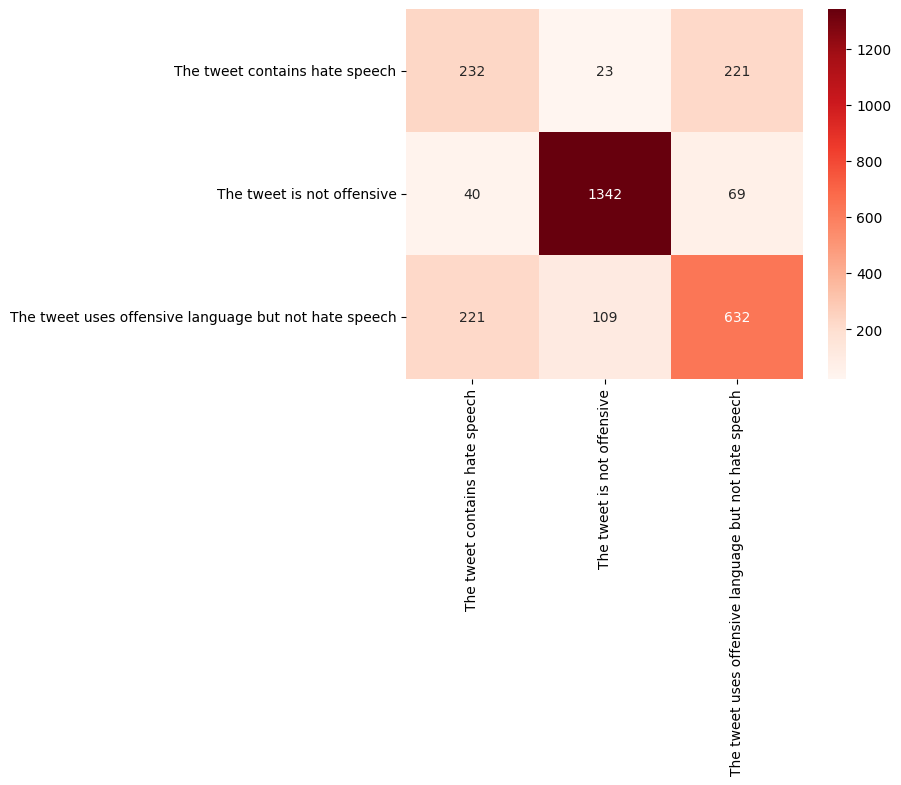

In [19]:
# Generate confusion matrix and plot heatmap
cnf = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cnf, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap="Reds");

In [20]:
# Save the model
model.save('../model/LSTM_model.h5')
print("\nModel saved !")


Model saved !
